<a href="https://colab.research.google.com/github/Abi-Lowkey/Introduction-to-Machine-Learning-with-Python-Books/blob/main/UASMachineLearning/Unit_1_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Feature Matching**  
Detected features can be matched from one image to another. Feature matching involves comparing key attributes from different images to find similarities. It is useful in many computer vision applications, including scene understanding, image stitching, object tracking, and pattern recognition.

**Brute-Force Search**  
Imagine a large box filled with puzzle pieces, and you're trying to find a specific piece that fits into your puzzle. This is similar to searching for matching features between images. Without using any special strategy, each piece is checked one by one until the correct one is found. This direct method is called brute-force search. The advantage of brute force is its simplicity. No special tricks are needed – just patience. However, it can be time-consuming, especially if there are many pieces to check. In the context of feature matching, this brute-force approach is akin to comparing every pixel in one image with every pixel in another to see if there’s a match. It is exhaustive and may take a lot of time, especially for large images.

Now that we have an intuitive understanding of how brute-force matching works, the algorithms will be explored further. The descriptors learned in the previous chapter will be used to find matching features in two images.

### **First** install and load libraries

In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import numpy as np

**Brute Force with SIFT**

In [ ]:
# Load the images
img1 = cv2.imread('/content/img1.jpg', cv2.IMREAD_GRAYSCALE)  # Replace with the actual path to your image
img2 = cv2.imread('/content/ing2.jpg', cv2.IMREAD_GRAYSCALE)  # Replace with the actual path to your image

Let’s start by initializing SIFT detector.

In [ ]:
sift = cv2.SIFT_create()

Find the keypoints and descriptors with SIFT.

In [ ]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

Find matches using k nearest neighbors.

In [ ]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

Apply ratio test to threshold the best matches.

In [ ]:
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

Draw the matches.

In [ ]:
img3 = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

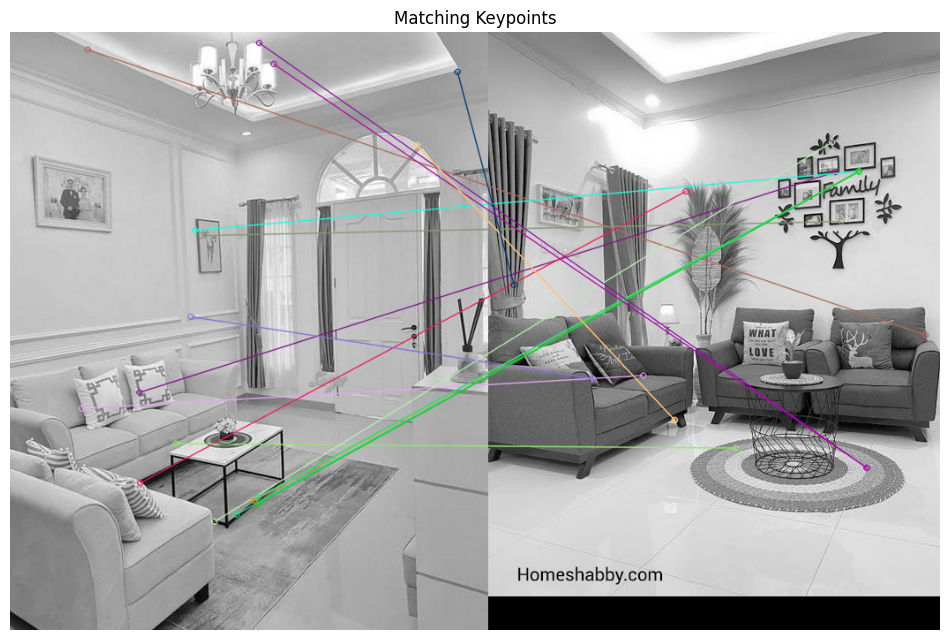

In [ ]:
import matplotlib.pyplot as plt

# Menampilkan gambar menggunakan Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(img3, cmap='gray')
plt.title('Matching Keypoints')
plt.axis('off')  # Menghilangkan sumbu
plt.show()


### **Brute Force with ORB (binary) descriptors**

Initialize the ORB descriptor.

In [ ]:
orb = cv2.ORB_create()

Find keypoints and descriptors.

In [ ]:
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

Because ORB is a binary descriptor, we find matches using Hamming Distance, which is a measure of the difference between two strings of equal length.

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

We will now find the matches.

In [ ]:
matches = bf.match(des1, des2)

We can sort them in the order of their distance like the following.

In [ ]:
matches = sorted(matches, key=lambda x: x.distance)

Draw first n matches.



In [ ]:
n = 10
img3 = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    matches[:n],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

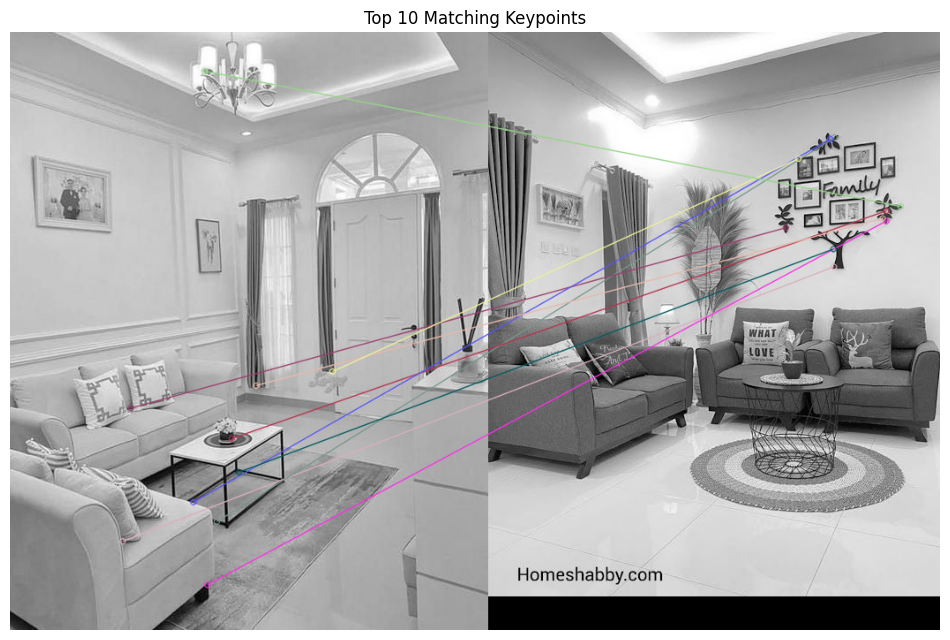

In [ ]:
import matplotlib.pyplot as plt

# Menampilkan gambar hasil pencocokan keypoints
plt.figure(figsize=(12, 8))
plt.imshow(img3, cmap='gray')
plt.title('Top 10 Matching Keypoints')
plt.axis('off')  # Menghilangkan sumbu
plt.show()


## **Fast Library for Approximate Nearest Neighbors (FLANN)**

FLANN, proposed in *Fast Approximate Nearest Neighbors With Automatic Algorithm Configuration* by Muja and Lowe, can be explained using the analogy of solving a puzzle. A large puzzle with hundreds of scattered pieces is visualized, and the task is to organize these pieces based on how well they fit together. Instead of testing each piece against every other piece, clever tricks are employed by FLANN to streamline the matching process.

Rather than randomly matching all pieces, pieces that are most likely to fit together are identified by FLANN based on approximate similarity. This approach allows educated guesses to be made about which pieces might fit, even without an exact match.

Under the hood, something called *k-D trees* is used by FLANN. Puzzle pieces are organized into a special tree-like structure that speeds up the search. In each node of the *k-D tree*, pieces with similar features are grouped together. This enables the search to focus only on the most likely pile of similar pieces.

For instance, if a "sky" puzzle piece is being searched for, the search is guided by FLANN to the section of the *k-D tree* where sky-colored pieces have been sorted. The strategy employed by FLANN is also adjusted based on the features of the puzzle pieces. In a puzzle with many colors, more attention is given to color features. Conversely, in a puzzle with intricate shapes, shape features are prioritized.

By balancing speed and accuracy in finding matching features, significant improvements in query time are achieved by FLANN.

First, we create a dictionary to specify the algorithm we will use, for SIFT or SURF it looks like the following.



In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)

For ORB, will use the parameters from the paper.



In [ ]:
FLANN_INDEX_LSH = 6
index_params = dict(
    algorithm=FLANN_INDEX_LSH, table_number=12, key_size=20, multi_probe_level=2
)

We also create a dictionary to specify the maximum leafs to visit as follows.



In [ ]:
search_params = dict(checks=50)


Initiate SIFT detector



In [ ]:
sift = cv2.SIFT_create()

Find the keypoints and descriptors with SIFT



In [ ]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [ ]:
print(des1.dtype)

uint8


In [ ]:
if des1.dtype != np.float32:
    des1 = des1.astype(np.float32)
    des2 = des2.astype(np.float32)

We will now define the FLANN parameters. Here, trees is the number of bins you want.



In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

We will only draw good matches, so create a mask.



In [ ]:
matchesMask = [[0, 0] for i in range(len(matches))]

We can perform a ratio test to determine good matches.



In [ ]:
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

Now let’s visualize the matches.



In [ ]:
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=(255, 0, 0),
    matchesMask=matchesMask,
    flags=cv2.DrawMatchesFlags_DEFAULT,
)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

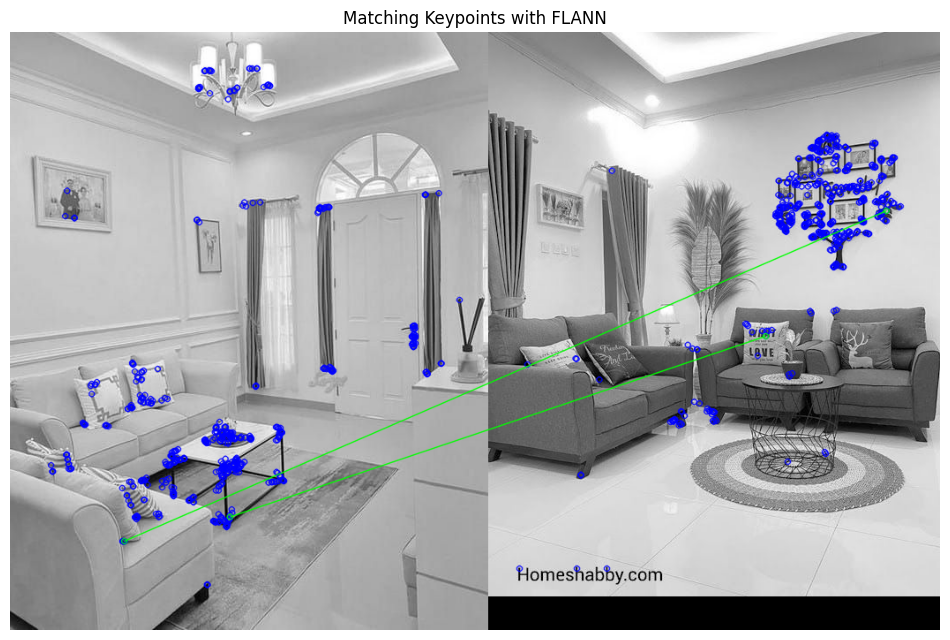

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Tampilkan hasil gambar img3 menggunakan Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))  # Konversi BGR ke RGB
plt.title('Matching Keypoints with FLANN')
plt.axis('off')  # Sembunyikan sumbu
plt.show()


### **#Local Feature Matching with Transformers (LoFTR)**

LoFTR, proposed in *LoFTR: Detector-Free Local Feature Matching with Transformers* by Sun et al., takes a learning-based approach to feature matching, bypassing traditional feature detectors.

Using the puzzle analogy again, LoFTR simplifies feature matching by focusing on specific key points or features in images, much like identifying the distinctive corners and edges of puzzle pieces. Just as a skilled puzzle solver might concentrate on unique marks or shapes, LoFTR identifies standout landmarks or structures in images to assist in matching.

One key advantage of LoFTR is its ability to handle transformations such as rotation and scaling. For example, even if a feature is flipped or resized, it can still be recognized, akin to solving puzzles with pieces that may have been rotated or adjusted. When features are matched, LoFTR assigns a similarity score to indicate how well the features align—higher scores representing better matches, much like grading how well two puzzle pieces fit together.

Additionally, LoFTR is invariant to various transformations, including changes in lighting, angle, or perspective. This robustness is essential for working with images captured under different conditions. Its ability to reliably match features makes LoFTR particularly valuable for tasks such as image stitching, where multiple images need to be seamlessly combined by identifying and aligning common features.

We can use Kornia to find matching features in two images using LoFTR.



In [ ]:
!pip install kornia  kornia-rs  kornia_moons opencv-python --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.9 MB/s eta 0:00:00


Import the necessary libraries.



In [ ]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

Load and resize the images.



In [ ]:
from kornia.feature import LoFTR

img1 = K.io.load_image('/content/image 1.jpg', K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image('/content/image 2.jpg', K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)

Indicate whether the image is an “indoor” or “outdoor” image.



In [ ]:
matcher = LoFTR(pretrained="outdoor")

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt
100%|██████████| 44.2M/44.2M [00:01<00:00, 24.0MB/s]


LoFTR only works on grayscale images, so convert to images to grayscale.



In [ ]:
input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

Let’s perform the inference.



In [ ]:
with torch.inference_mode():
    correspondences = matcher(input_dict)

Clean up the correspondences using Random Sample Consensus (RANSAC). This helps to deal with noise or outliers in the data.



In [ ]:
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

Finally, we can visualize the matches



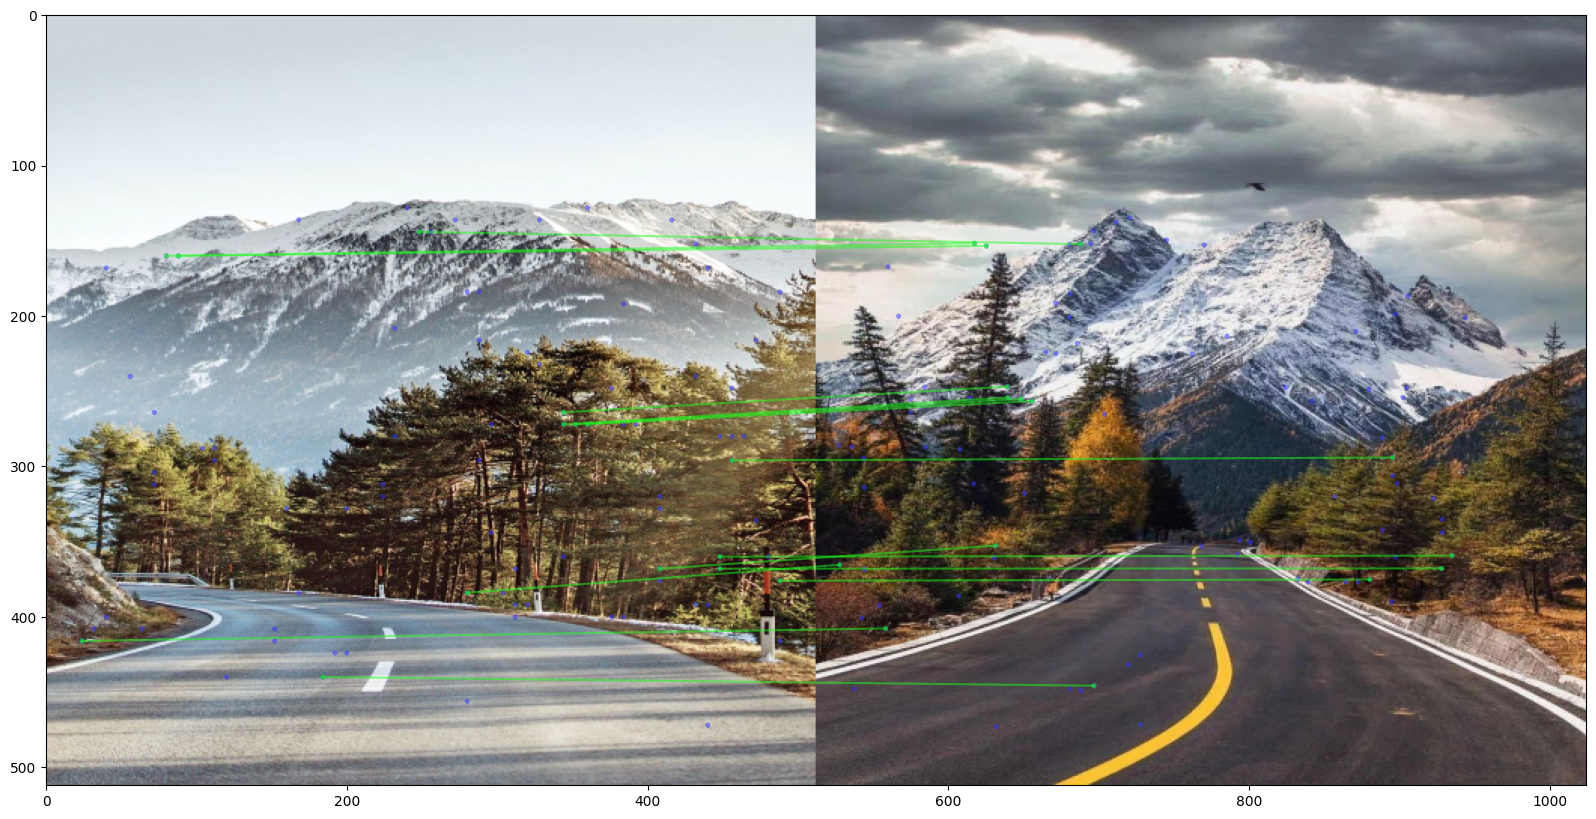

In [ ]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.1, 1, 0.1, 0.5),
        "tentative_color": None,
        "feature_color": (0.2, 0.2, 1, 0.5),
        "vertical": False,
    },
)